# The Nature Conservancy

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import pandas as pd
%matplotlib inline

In [2]:
TRAIN_DIR = 'data/fish/train/'

TEST_DIR  = 'data/fish/test_stg1/**/'

sub_folders = check_output(["ls", TRAIN_DIR]).decode("utf8").strip().split('\n')

FISH_CLASSES = sub_folders

print(sub_folders)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


**Посмотрим на тренировочную выборку**

In [3]:
img_width, img_height = 224, 224
num_channels = 3

def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

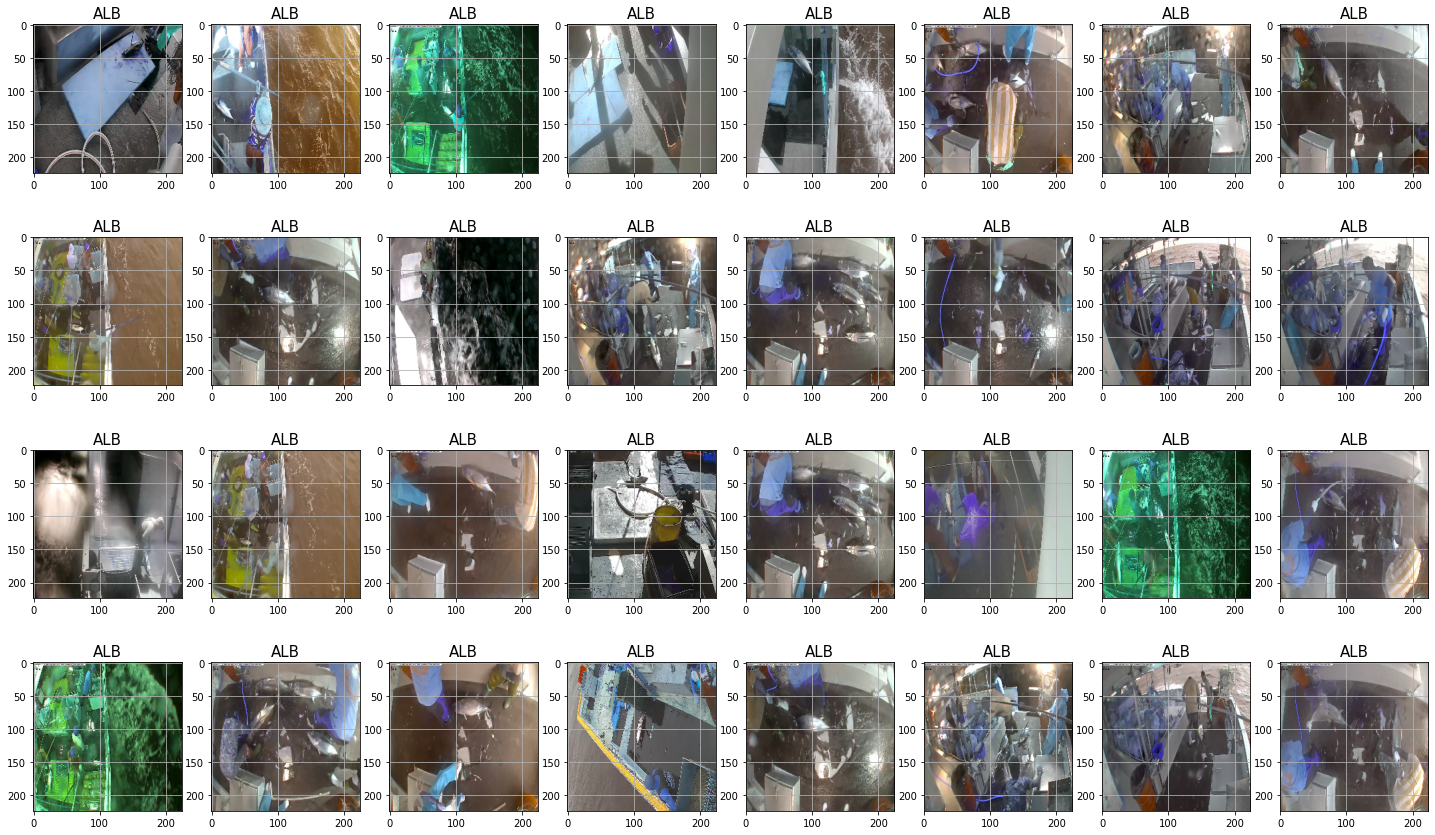

In [4]:
import glob

images = []
label_photos = []
images_path = []

for sub_dir in sub_folders:
    index = sub_folders.index(sub_dir)
    path = os.path.join(TRAIN_DIR, sub_dir, '*g')
    files = glob.glob(path)#'data/fish/train/YFT/img_07038.jpg'
    for file in files:
        file_name = os.path.basename(file)#'img_06053.jpg'
        img = load_images(file)#array([[[180, 202, 200]...
        images.append(img)#array([[[255, 255, 254]
        label_photos.append(sub_dir)
        images_path.append(file)

        
fig, axs = plt.subplots(4, 8, figsize=(25, 15))

for ax, img, label in zip(axs.flatten(), images, label_photos):
    ax.set_title(label, fontsize=15)
    ax.imshow(img)
    ax.grid(True)

plt.show()        

**Сформируем датасет для классификации рыб**

In [5]:
label_photos[25:30]

['ALB', 'ALB', 'ALB', 'ALB', 'ALB']

In [6]:
#количество классов
num_classes = len(np.unique(label_photos))
num_classes

8

In [7]:
df = pd.DataFrame()

df['path']=images_path
df['labels'] = label_photos

df

,path,labels
0,data/fish/train/ALB/img_04547.jpg,ALB
1,data/fish/train/ALB/img_02689.jpg,ALB
2,data/fish/train/ALB/img_03304.jpg,ALB
3,data/fish/train/ALB/img_05214.jpg,ALB
4,data/fish/train/ALB/img_05093.jpg,ALB
...,...,...
3772,data/fish/train/YFT/img_00184.jpg,YFT
3773,data/fish/train/YFT/img_02846.jpg,YFT
3774,data/fish/train/YFT/img_00221.jpg,YFT
3775,data/fish/train/YFT/img_07775.jpg,YFT


In [8]:
#разделим тестовую и трейновую выборки
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, 
                                   test_size = 0.20, 
                                   random_state = 2)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 3021 validation 756


In [9]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (100, 100)

batch_size=2

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 3021 validated image filenames belonging to 8 classes.


In [10]:
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 756 validated image filenames belonging to 8 classes.


In [11]:
train_df.sample(n=1).reset_index(drop=True)

,path,labels
0,data/fish/train/ALB/img_03698.jpg,ALB


In [12]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,  
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


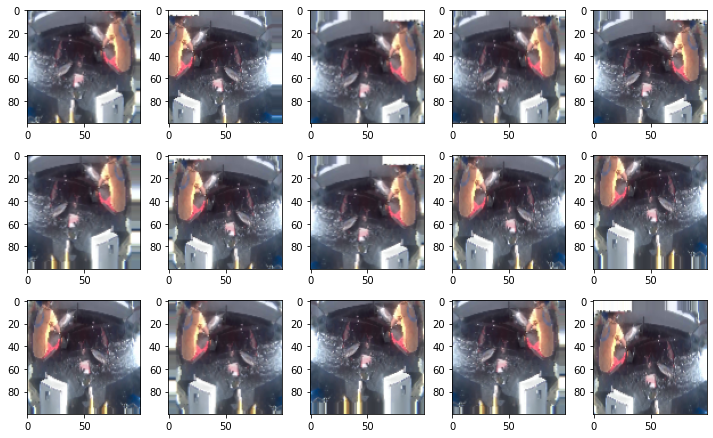

In [13]:
plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 5, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Обучение**

In [14]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

In [15]:
num_classes

8

In [18]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet',#предварительное обучение на ImageNet
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [19]:
# дообучаем последние 5 слоев
for layer in base_model.layers[:-5]:
    layer.trainable = False
    print(layer)

In [20]:
from tensorflow.keras.layers import Flatten, Dense
import tensorflow as tf


x = base_model.layers[-1].output
x = tf.keras.layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(num_classes,  
                          activation='softmax',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='detect_fish') 
model.summary()

Model: "detect_fish"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       

In [21]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint("vgg_best_Model.h5",save_best_only=True)

In [26]:
import tensorflow as tf

batch_size = 5

with tf.device('/gpu:0'):
    history=model.fit_generator(train_generator,
                        steps_per_epoch=train_df.shape[0]//batch_size,
                        validation_steps=valid_df.shape[0]//batch_size,
                        validation_data=valid_generator,
                        epochs = 30,
                        callbacks=[model_checkpoint_callback],
                        )

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
604/604 [==============================] - 138s 226ms/step - loss: 0.4000 - accuracy: 0.4060 - val_loss: 1.2306 - val_accuracy: 0.1887
Epoch 2/30
604/604 [==============================] - 121s 201ms/step - loss: 0.3184 - accuracy: 0.5145 - val_loss: 0.2979 - val_accuracy: 0.5232
Epoch 3/30
604/604 [==============================] - 114s 188ms/step - loss: 0.2753 - accuracy: 0.5829 - val_loss: 0.3070 - val_accuracy: 0.3940
Epoch 4/30
604/604 [==============================] - 119s 197ms/step - loss: 0.2491 - accuracy: 0.6198 - val_loss: 0.2736 - val_accuracy: 0.6291
Epoch 5/30
604/604 [==============================] - 176s 291ms/step - loss: 0.2402 - accuracy: 0.6458 - val_loss: 1.1990 - val_accuracy: 0.1026
Epoch 6/30
604/604 [==============================] - 246s 408ms/step - loss: 0.2383 - accuracy: 0.6477 - val_loss: 0.2327 - val_accuracy: 0.6689
Epoch 7/30
604/604 [==============================] - 168s 278ms/step - loss: 0.2028 - accuracy: 0.7101 - val_loss: 0.2222 -

In [27]:
print("Train Accuracy:{:.3f}".format(model.history.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(history.history['val_accuracy'][-1]))

Train Accuracy:0.945
Test Accuracy:0.877


**Классификация неразмеченных данных**

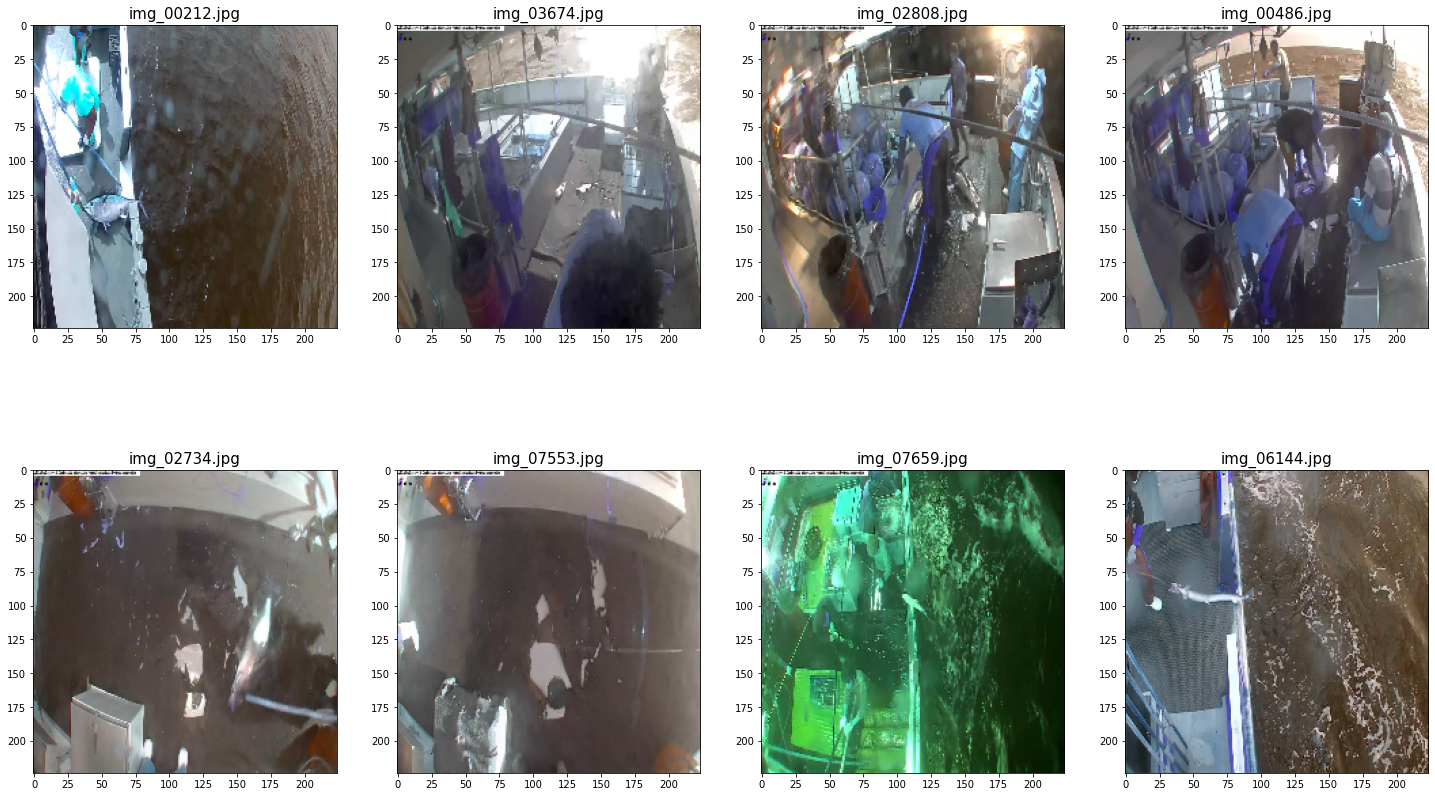

In [28]:
#отобразим эти данные
images_test = []
label_images = []
images_test_path = []



path = os.path.join(TEST_DIR, '*g')
files = glob.glob(path, recursive=True)

for file in files:
    file_name = os.path.basename(file)#'img_06053.jpg'
    img = load_images(file)#array([[[180, 202, 200]...
    images_test.append(img)#array([[[255, 255, 254]
    label_images.append(file_name)
    images_test_path.append(file)

        
fig, axs = plt.subplots(2, 4, figsize=(25, 15))

for ax, img, label in zip(axs.flatten(), images_test, label_images):
    ax.set_title(label, fontsize=15)
    ax.imshow(img)


plt.show()        

In [62]:
test_df = pd.DataFrame()

test_df['path'] = images_test_path
test_df['image'] = test_df['path'].map(lambda x: x.split('test_stg1/')[1])
test_df.head()

,path,image
0,data/fish/test_stg1/img_00212.jpg,img_00212.jpg
1,data/fish/test_stg1/img_03674.jpg,img_03674.jpg
2,data/fish/test_stg1/img_02808.jpg,img_02808.jpg
3,data/fish/test_stg1/img_00486.jpg,img_00486.jpg
4,data/fish/test_stg1/img_02734.jpg,img_02734.jpg


In [63]:
test_df

,path,image
0,data/fish/test_stg1/img_00212.jpg,img_00212.jpg
1,data/fish/test_stg1/img_03674.jpg,img_03674.jpg
2,data/fish/test_stg1/img_02808.jpg,img_02808.jpg
3,data/fish/test_stg1/img_00486.jpg,img_00486.jpg
4,data/fish/test_stg1/img_02734.jpg,img_02734.jpg
...,...,...
13148,data/fish/test_stg1/test_stg2/image_01875.jpg,test_stg2/image_01875.jpg
13149,data/fish/test_stg1/test_stg2/image_01823.jpg,test_stg2/image_01823.jpg
13150,data/fish/test_stg1/test_stg2/image_02389.jpg,test_stg2/image_02389.jpg
13151,data/fish/test_stg1/test_stg2/image_05974.jpg,test_stg2/image_05974.jpg


In [59]:
test_df['path'].map(lambda x: x.split('test_stg1/')[1])

0                    img_00212.jpg
1                    img_03674.jpg
2                    img_02808.jpg
3                    img_00486.jpg
4                    img_02734.jpg
                   ...            
13148    test_stg2/image_01875.jpg
13149    test_stg2/image_01823.jpg
13150    test_stg2/image_02389.jpg
13151    test_stg2/image_05974.jpg
13152    test_stg2/image_10089.jpg
Name: path, Length: 13153, dtype: object

In [64]:
IMG_SIZE = (100, 100)

batch_size=2

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="image",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',)

Found 13153 validated image filenames belonging to 13153 classes.


In [33]:
#предсказываем
pred_Y =  model.predict_generator(test_generator, verbose = 1)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


6577/6577 [==============================] - 875s 133ms/step


In [34]:
#вероятность для каждого класса
pred_Y[0]

array([1.6361870e-05, 3.5919521e-07, 2.5617296e-04, 6.7750960e-07,
       9.9955612e-01, 2.7043557e-08, 4.0583249e-08, 1.7028498e-04],
      dtype=float32)

In [65]:
unique_labels = np.unique(label_photos)
unique_labels

array(['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'],
      dtype='<U5')

In [66]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder.fit(unique_labels)
encoder.transform(unique_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [67]:
for i,label in enumerate(list(unique_labels)):
    print(i,label)

0 ALB
1 BET
2 DOL
3 LAG
4 NoF
5 OTHER
6 SHARK
7 YFT


In [70]:
submission = pd.DataFrame()
submission['image'] = test_df['image']

for i,label in enumerate(list(unique_labels)):
    submission[label] = pred_Y[:,i]

In [71]:
#классификация рыб. По оси y - номера изображений
submission

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00212.jpg,0.000016,3.591952e-07,0.000256,6.775096e-07,0.999556,2.704356e-08,4.058325e-08,0.000170
1,img_03674.jpg,0.348516,1.653177e-02,0.026270,3.111946e-01,0.037966,1.466174e-02,8.266225e-02,0.162197
2,img_02808.jpg,0.040183,8.078257e-01,0.041121,9.328820e-03,0.057640,3.116629e-02,1.040728e-02,0.002328
3,img_00486.jpg,0.123735,8.023426e-01,0.026456,4.218046e-03,0.013494,2.461139e-02,3.246766e-03,0.001896
4,img_02734.jpg,0.000673,4.381931e-01,0.000884,4.836902e-05,0.558059,1.632972e-04,2.282741e-05,0.001957
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_01875.jpg,0.269601,4.363450e-01,0.083833,5.664922e-05,0.199441,9.343899e-03,1.317356e-04,0.001248
13149,test_stg2/image_01823.jpg,0.032908,7.115530e-01,0.130967,6.085661e-03,0.078221,8.069637e-03,8.590034e-03,0.023606
13150,test_stg2/image_02389.jpg,0.714562,1.156945e-04,0.010012,3.148562e-04,0.272292,1.777443e-03,1.240792e-04,0.000802
13151,test_stg2/image_05974.jpg,0.085741,6.362877e-01,0.029033,1.356431e-02,0.107111,3.138307e-02,9.632736e-03,0.087247


In [73]:
submission.to_csv('submission.csv', sep=',' , index=False)